## Train XGBoost Model
**Ayush Noori**

First, I load the relevant libraries.

In [1]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
from matplotlib import colors # colors for histogram
%matplotlib inline

# TDC library
from tdc.benchmark_group import admet_group
from tdc.chem_utils import MolConvert

# XGBoost
import xgboost as xgb

# import Optuna
import optuna
from optuna.samplers import TPESampler
import optuna.visualization.matplotlib as oviz

# logging to show Optuna output
import logging
import sys

# metrics for ROC/AUC
from sklearn import metrics

# time management
from datetime import datetime

# create time object used for file names
my_time = datetime.now()

In [2]:
group = admet_group(path = 'data/')
predictions_list = []

Found local copy...


Next, I retrieve the data.

In [3]:
# set seed and benchmark in benchmark group
seed = 1
benchmark = group.get('BBB_Martins') 
    
# all benchmark names in a benchmark group are stored in group.dataset_names
predictions = {}
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']
# train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

I define the XGBoost training function. First, I convert the SMILES structures to fingerprints. Note that conversion from `SMILES` to `RDKit2D` requires `pip install git+https://github.com/bp-kelley/descriptastorus` and `pip install pandas-flavor`.

The parameter definition code was inspired by [this Medium post](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407) with [this source code](https://gist.github.com/Crissman/4ddeec6718627ecef46f863e1bf90424#file-xgboost_integration-py). See [the documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) for a full list of possible parameters.

In [4]:
# define training function
def train_xgboost(trial):

    # define fingerprint
    mol_dst = trial.suggest_categorical("mol_dst", ["ECFP2", "ECFP4", "MACCS", "Morgan", "Daylight", "RDKit2D"])

    # define the XGBoost parameters, inspired by 
    params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # print all of the hyperparameters of the training iteration:
    print("\n===== TRIAL #{} =====".format(trial.number))
    print("Fingerprint: {}".format(mol_dst))
    print("Booster: {}".format(params["booster"]))
    print("Lambda: {}".format(params["lambda"]))
    print("Alpha: {}".format(params["alpha"]))

    # convert fingerprint
    converter = MolConvert(src = 'SMILES', dst = mol_dst)
    train_val_features = pd.DataFrame([converter(x) for x in train_val['Drug']])

    # define the optimized DMatrix object
    dtrain_val = xgb.DMatrix(train_val_features, label = train_val['Y'])

    # perform cross-validation
    cv_results = xgb.cv(dtrain = dtrain_val, params = params, nfold = 5, \
        num_boost_round = 100, early_stopping_rounds = 10, metrics = "auc", as_pandas = True, seed = seed)

    # train final model based on parameters in Optuna trial
    xgb_model = xgb.train(dtrain = dtrain_val, params = params, num_boost_round = 50)

    # report the final boosting metric as the summary metric for this Optuna trial
    test_auc_mean = cv_results["test-auc-mean"].tail(1)

    # return model and metric
    return xgb_model, test_auc_mean

I define the Optuna objective function.

In [5]:
# define directories
optuna_dir = "optuna/"
model_dir = optuna_dir + "models/"
study_dir = optuna_dir + "database/"

# define objective function
def objective(trial):

    # start the training loop
    trial_xgb_model, trial_test_auc_mean = train_xgboost(trial)

    # save model for this loop
    trial_xgb_model.save_model(model_dir + "xgboost_model_{}.json".format(trial.number))

    return trial_test_auc_mean

I run the Optuna trials.

In [6]:
# add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# create study
study_name = "xgboost-study"  # unique identifier of the study
storage_name = "sqlite:///{}.db".format(study_dir + study_name)
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed = 1234, multivariate = True), study_name = study_name, storage = storage_name, load_if_exists = True)

# optimize hyperparameters
study.optimize(objective, n_trials = 50, gc_after_trial = True)

[I 2022-05-05 02:04:12,662] Using an existing study with name 'xgboost-study' instead of creating a new one.


Using an existing study with name 'xgboost-study' instead of creating a new one.


[W 2022-05-05 02:04:13,181] The parameter 'max_depth' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,261] The parameter 'eta' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,320] The parameter 'gamma' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,382] The parameter 'grow_policy' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,426] The parameter 'sample_type' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,479] The parameter 'normalize_type' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,532] The parameter 'rate_drop' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:04:13,596] The parameter 'skip_drop' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#150 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #150 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.1398510237637687
Alpha: 0.4200632616102525


[I 2022-05-05 02:10:29,470] Trial 150 finished with value: 0.9127588980971636 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.1398510237637687, 'alpha': 0.4200632616102525, 'max_depth': 9, 'eta': 0.23658507581256213, 'gamma': 1.1779334573718214e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00027751173492367225, 'skip_drop': 1.3536485194214702e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 150 finished with value: 0.9127588980971636 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.1398510237637687, 'alpha': 0.4200632616102525, 'max_depth': 9, 'eta': 0.23658507581256213, 'gamma': 1.1779334573718214e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00027751173492367225, 'skip_drop': 1.3536485194214702e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 02:10:29,768] The parameter 'max_depth' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:29,812] The parameter 'eta' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:29,858] The parameter 'gamma' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:29,903] The parameter 'grow_policy' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:29,941] The parameter 'sample_type' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:29,983] The parameter 'normalize_type' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:30,020] The parameter 'rate_drop' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:10:30,063] The parameter 'skip_drop' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#151 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #151 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 0.18158197445232235
Alpha: 0.16402729122803048


[I 2022-05-05 02:13:35,611] Trial 151 finished with value: 0.914211313949246 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.18158197445232235, 'alpha': 0.16402729122803048, 'max_depth': 9, 'eta': 0.13672216786804622, 'gamma': 1.7003080927777646e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2174230294310574e-05, 'skip_drop': 2.091538915839185e-07}. Best is trial 140 with value: 0.9194219521165913.


Trial 151 finished with value: 0.914211313949246 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.18158197445232235, 'alpha': 0.16402729122803048, 'max_depth': 9, 'eta': 0.13672216786804622, 'gamma': 1.7003080927777646e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2174230294310574e-05, 'skip_drop': 2.091538915839185e-07}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 02:13:36,164] The parameter 'max_depth' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,248] The parameter 'eta' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,331] The parameter 'gamma' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,413] The parameter 'grow_policy' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,480] The parameter 'sample_type' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,551] The parameter 'normalize_type' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,618] The parameter 'rate_drop' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:13:36,703] The parameter 'skip_drop' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #152 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.004016595087569602
Alpha: 0.03710426159647412


[I 2022-05-05 02:18:37,925] Trial 152 finished with value: 0.9019536806420021 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.004016595087569602, 'alpha': 0.03710426159647412, 'max_depth': 9, 'eta': 0.015376918334177815, 'gamma': 1.9301532564210515e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003492341346379726, 'skip_drop': 1.0813747927028513e-08}. Best is trial 140 with value: 0.9194219521165913.


Trial 152 finished with value: 0.9019536806420021 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.004016595087569602, 'alpha': 0.03710426159647412, 'max_depth': 9, 'eta': 0.015376918334177815, 'gamma': 1.9301532564210515e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003492341346379726, 'skip_drop': 1.0813747927028513e-08}. Best is trial 140 with value: 0.9194219521165913.


[W 2022-05-05 02:18:38,309] The parameter 'max_depth' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,378] The parameter 'eta' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,441] The parameter 'gamma' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,503] The parameter 'grow_policy' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,551] The parameter 'sample_type' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,602] The parameter 'normalize_type' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,653] The parameter 'rate_drop' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:18:38,713] The parameter 'skip_drop' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#153 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #153 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.06938857714778546
Alpha: 0.12580288304890974


[I 2022-05-05 02:22:34,246] Trial 153 finished with value: 0.919911132859976 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.06938857714778546, 'alpha': 0.12580288304890974, 'max_depth': 8, 'eta': 0.2041851588470187, 'gamma': 1.1863210641172191e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.694743713660247e-05, 'skip_drop': 1.5978768990039328e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 153 finished with value: 0.919911132859976 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.06938857714778546, 'alpha': 0.12580288304890974, 'max_depth': 8, 'eta': 0.2041851588470187, 'gamma': 1.1863210641172191e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.694743713660247e-05, 'skip_drop': 1.5978768990039328e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:22:34,651] The parameter 'max_depth' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,708] The parameter 'eta' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,769] The parameter 'gamma' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,830] The parameter 'grow_policy' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,880] The parameter 'sample_type' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,934] The parameter 'normalize_type' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:34,986] The parameter 'rate_drop' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:22:35,061] The parameter 'skip_drop' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#154 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #154 =====
Fingerprint: Daylight
Booster: dart
Lambda: 0.07746447587052441
Alpha: 0.20698852040192298


[I 2022-05-05 02:30:42,927] Trial 154 finished with value: 0.876884845603524 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.07746447587052441, 'alpha': 0.20698852040192298, 'max_depth': 8, 'eta': 0.02499094289673757, 'gamma': 0.00631656024119013, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.9878609451483467e-06, 'skip_drop': 8.073088062999617e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 154 finished with value: 0.876884845603524 and parameters: {'mol_dst': 'Daylight', 'booster': 'dart', 'lambda': 0.07746447587052441, 'alpha': 0.20698852040192298, 'max_depth': 8, 'eta': 0.02499094289673757, 'gamma': 0.00631656024119013, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.9878609451483467e-06, 'skip_drop': 8.073088062999617e-07}. Best is trial 153 with value: 0.919911132859976.

===== TRIAL #155 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 0.006540315610421202
Alpha: 0.01867958678236709


[I 2022-05-05 02:34:01,279] Trial 155 finished with value: 0.8572302924450828 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.006540315610421202, 'alpha': 0.01867958678236709}. Best is trial 153 with value: 0.919911132859976.


Trial 155 finished with value: 0.8572302924450828 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.006540315610421202, 'alpha': 0.01867958678236709}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:34:01,673] The parameter 'max_depth' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:34:01,734] The parameter 'eta' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:34:01,824] The parameter 'gamma' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:34:01,897] The parameter 'grow_policy' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#156 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #156 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.22824743271781314
Alpha: 0.1290953933243105


[I 2022-05-05 02:37:23,961] Trial 156 finished with value: 0.9192610431117176 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.22824743271781314, 'alpha': 0.1290953933243105, 'max_depth': 7, 'eta': 0.18882239976895623, 'gamma': 0.0002513045351569037, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 156 finished with value: 0.9192610431117176 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.22824743271781314, 'alpha': 0.1290953933243105, 'max_depth': 7, 'eta': 0.18882239976895623, 'gamma': 0.0002513045351569037, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:37:24,406] The parameter 'max_depth' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:37:24,468] The parameter 'eta' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:37:24,533] The parameter 'gamma' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:37:24,605] The parameter 'grow_policy' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#157 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #157 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.04275229448537253
Alpha: 0.11195627785895508


[I 2022-05-05 02:40:50,709] Trial 157 finished with value: 0.9045211811981637 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.04275229448537253, 'alpha': 0.11195627785895508, 'max_depth': 6, 'eta': 0.6904779134463643, 'gamma': 7.004626077547825e-05, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 157 finished with value: 0.9045211811981637 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.04275229448537253, 'alpha': 0.11195627785895508, 'max_depth': 6, 'eta': 0.6904779134463643, 'gamma': 7.004626077547825e-05, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:40:51,127] The parameter 'max_depth' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,186] The parameter 'eta' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,261] The parameter 'gamma' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,323] The parameter 'grow_policy' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,378] The parameter 'sample_type' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,435] The parameter 'normalize_type' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,492] The parameter 'rate_drop' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:40:51,559] The parameter 'skip_drop' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #158 =====
Fingerprint: ECFP4
Booster: dart
Lambda: 0.00016041393774996704
Alpha: 0.0796016804606285


[I 2022-05-05 02:49:03,304] Trial 158 finished with value: 0.8947036621256791 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.00016041393774996704, 'alpha': 0.0796016804606285, 'max_depth': 8, 'eta': 0.9980480403073826, 'gamma': 1.2705887345912864e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.6827939228912114e-06, 'skip_drop': 9.983218360370666e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 158 finished with value: 0.8947036621256791 and parameters: {'mol_dst': 'ECFP4', 'booster': 'dart', 'lambda': 0.00016041393774996704, 'alpha': 0.0796016804606285, 'max_depth': 8, 'eta': 0.9980480403073826, 'gamma': 1.2705887345912864e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.6827939228912114e-06, 'skip_drop': 9.983218360370666e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:49:03,757] The parameter 'max_depth' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:49:03,821] The parameter 'eta' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:49:03,893] The parameter 'gamma' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:49:03,963] The parameter 'grow_policy' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #159 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.11681753227386843
Alpha: 0.21755408645302388


[I 2022-05-05 02:52:31,472] Trial 159 finished with value: 0.918465877172765 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.11681753227386843, 'alpha': 0.21755408645302388, 'max_depth': 6, 'eta': 0.06914944695583157, 'gamma': 0.00014706887073050206, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 159 finished with value: 0.918465877172765 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.11681753227386843, 'alpha': 0.21755408645302388, 'max_depth': 6, 'eta': 0.06914944695583157, 'gamma': 0.00014706887073050206, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:52:31,912] The parameter 'max_depth' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:31,974] The parameter 'eta' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:32,063] The parameter 'gamma' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:32,134] The parameter 'grow_policy' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#160 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #160 =====
Fingerprint: MACCS
Booster: gbtree
Lambda: 0.06894016093926947
Alpha: 0.3629023385528285


[I 2022-05-05 02:52:46,162] Trial 160 finished with value: 0.9059381307944209 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.06894016093926947, 'alpha': 0.3629023385528285, 'max_depth': 6, 'eta': 0.08524503158232158, 'gamma': 0.00010252301724159144, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 160 finished with value: 0.9059381307944209 and parameters: {'mol_dst': 'MACCS', 'booster': 'gbtree', 'lambda': 0.06894016093926947, 'alpha': 0.3629023385528285, 'max_depth': 6, 'eta': 0.08524503158232158, 'gamma': 0.00010252301724159144, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:52:46,567] The parameter 'max_depth' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:46,625] The parameter 'eta' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:46,696] The parameter 'gamma' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:52:46,772] The parameter 'grow_policy' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#161 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #161 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.022306550338357337
Alpha: 0.47416289613625057


[I 2022-05-05 02:56:25,731] Trial 161 finished with value: 0.9180940315566524 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.022306550338357337, 'alpha': 0.47416289613625057, 'max_depth': 5, 'eta': 0.07790558256597795, 'gamma': 6.666449726626205e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 161 finished with value: 0.9180940315566524 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.022306550338357337, 'alpha': 0.47416289613625057, 'max_depth': 5, 'eta': 0.07790558256597795, 'gamma': 6.666449726626205e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:56:26,111] The parameter 'max_depth' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:56:26,171] The parameter 'eta' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:56:26,230] The parameter 'gamma' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:56:26,292] The parameter 'grow_policy' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#162 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #162 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.07467993740666626
Alpha: 0.017396233786135657


[I 2022-05-05 02:59:48,061] Trial 162 finished with value: 0.8908624239951871 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.07467993740666626, 'alpha': 0.017396233786135657, 'max_depth': 4, 'eta': 0.011476403731885397, 'gamma': 2.7746836883629556e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 162 finished with value: 0.8908624239951871 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.07467993740666626, 'alpha': 0.017396233786135657, 'max_depth': 4, 'eta': 0.011476403731885397, 'gamma': 2.7746836883629556e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 02:59:48,504] The parameter 'max_depth' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:59:48,572] The parameter 'eta' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:59:48,652] The parameter 'gamma' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 02:59:48,730] The parameter 'grow_policy' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#163 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #163 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.028312588162324036
Alpha: 0.04550290152051114


[I 2022-05-05 03:03:10,696] Trial 163 finished with value: 0.9128497306090818 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.028312588162324036, 'alpha': 0.04550290152051114, 'max_depth': 5, 'eta': 0.06701207204826597, 'gamma': 5.414183737810861e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 163 finished with value: 0.9128497306090818 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.028312588162324036, 'alpha': 0.04550290152051114, 'max_depth': 5, 'eta': 0.06701207204826597, 'gamma': 5.414183737810861e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:03:11,091] The parameter 'max_depth' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:03:11,155] The parameter 'eta' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:03:11,224] The parameter 'gamma' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:03:11,292] The parameter 'grow_policy' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#164 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #164 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.12138094664611912
Alpha: 0.8963401567251075


[I 2022-05-05 03:06:32,899] Trial 164 finished with value: 0.9190203536786689 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.12138094664611912, 'alpha': 0.8963401567251075, 'max_depth': 5, 'eta': 0.06831833811199937, 'gamma': 1.4667579384584303e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 164 finished with value: 0.9190203536786689 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.12138094664611912, 'alpha': 0.8963401567251075, 'max_depth': 5, 'eta': 0.06831833811199937, 'gamma': 1.4667579384584303e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:06:33,497] The parameter 'max_depth' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:06:33,579] The parameter 'eta' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:06:33,640] The parameter 'gamma' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:06:33,702] The parameter 'grow_policy' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#165 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #165 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.00923839924010538
Alpha: 0.5363021069221001


[I 2022-05-05 03:09:59,231] Trial 165 finished with value: 0.9124943316389696 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00923839924010538, 'alpha': 0.5363021069221001, 'max_depth': 4, 'eta': 0.10648766390429609, 'gamma': 2.411406418960464e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 165 finished with value: 0.9124943316389696 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00923839924010538, 'alpha': 0.5363021069221001, 'max_depth': 4, 'eta': 0.10648766390429609, 'gamma': 2.411406418960464e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:09:59,642] The parameter 'max_depth' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:09:59,706] The parameter 'eta' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:09:59,773] The parameter 'gamma' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:09:59,839] The parameter 'grow_policy' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#166 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #166 =====
Fingerprint: Daylight
Booster: gbtree
Lambda: 0.24109833934443997
Alpha: 0.11205189057144829


[I 2022-05-05 03:10:53,090] Trial 166 finished with value: 0.8962314285810811 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.24109833934443997, 'alpha': 0.11205189057144829, 'max_depth': 5, 'eta': 0.1323824078784065, 'gamma': 9.321733815235152e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 166 finished with value: 0.8962314285810811 and parameters: {'mol_dst': 'Daylight', 'booster': 'gbtree', 'lambda': 0.24109833934443997, 'alpha': 0.11205189057144829, 'max_depth': 5, 'eta': 0.1323824078784065, 'gamma': 9.321733815235152e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:10:53,497] The parameter 'max_depth' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:10:53,560] The parameter 'eta' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:10:53,633] The parameter 'gamma' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:10:53,696] The parameter 'grow_policy' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#167 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #167 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 0.17975046901363237
Alpha: 0.058682512775413524


[I 2022-05-05 03:11:39,441] Trial 167 finished with value: 0.905750296500843 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.17975046901363237, 'alpha': 0.058682512775413524, 'max_depth': 5, 'eta': 0.10191564842414957, 'gamma': 5.7587526695442274e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 167 finished with value: 0.905750296500843 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.17975046901363237, 'alpha': 0.058682512775413524, 'max_depth': 5, 'eta': 0.10191564842414957, 'gamma': 5.7587526695442274e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:11:39,884] The parameter 'max_depth' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:11:39,950] The parameter 'eta' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:11:40,025] The parameter 'gamma' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:11:40,092] The parameter 'grow_policy' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#168 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #168 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.7645182870997195
Alpha: 0.9873593197198502


[I 2022-05-05 03:15:04,023] Trial 168 finished with value: 0.8746835020947842 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.7645182870997195, 'alpha': 0.9873593197198502, 'max_depth': 5, 'eta': 0.006636052909791238, 'gamma': 2.0874326282106063e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 168 finished with value: 0.8746835020947842 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.7645182870997195, 'alpha': 0.9873593197198502, 'max_depth': 5, 'eta': 0.006636052909791238, 'gamma': 2.0874326282106063e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:15:04,431] The parameter 'max_depth' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:15:04,493] The parameter 'eta' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:15:04,557] The parameter 'gamma' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:15:04,627] The parameter 'grow_policy' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#169 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #169 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.08685341234034427
Alpha: 0.7494956953716801


[I 2022-05-05 03:18:25,190] Trial 169 finished with value: 0.9012562118373191 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.08685341234034427, 'alpha': 0.7494956953716801, 'max_depth': 5, 'eta': 0.7967476379119784, 'gamma': 0.0002755010493893463, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 169 finished with value: 0.9012562118373191 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.08685341234034427, 'alpha': 0.7494956953716801, 'max_depth': 5, 'eta': 0.7967476379119784, 'gamma': 0.0002755010493893463, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:18:25,614] The parameter 'max_depth' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:18:25,682] The parameter 'eta' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:18:25,750] The parameter 'gamma' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:18:25,818] The parameter 'grow_policy' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#170 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #170 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.10655687583880412
Alpha: 0.0036448326145376085


[I 2022-05-05 03:19:30,878] Trial 170 finished with value: 0.8821921177531366 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.10655687583880412, 'alpha': 0.0036448326145376085, 'max_depth': 6, 'eta': 0.015428766081876216, 'gamma': 3.3748729059446115e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 170 finished with value: 0.8821921177531366 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.10655687583880412, 'alpha': 0.0036448326145376085, 'max_depth': 6, 'eta': 0.015428766081876216, 'gamma': 3.3748729059446115e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:19:31,341] The parameter 'max_depth' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:19:31,407] The parameter 'eta' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:19:31,476] The parameter 'gamma' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:19:31,547] The parameter 'grow_policy' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#171 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #171 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.00010787396637467622
Alpha: 0.08332853043377433


[I 2022-05-05 03:23:07,252] Trial 171 finished with value: 0.9166526174323557 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00010787396637467622, 'alpha': 0.08332853043377433, 'max_depth': 7, 'eta': 0.04520375802414205, 'gamma': 0.00014409544960932382, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 171 finished with value: 0.9166526174323557 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00010787396637467622, 'alpha': 0.08332853043377433, 'max_depth': 7, 'eta': 0.04520375802414205, 'gamma': 0.00014409544960932382, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:23:07,672] The parameter 'max_depth' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:23:07,743] The parameter 'eta' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:23:07,831] The parameter 'gamma' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:23:07,906] The parameter 'grow_policy' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#172 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #172 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.49534752292586187
Alpha: 0.2669750821898311


[I 2022-05-05 03:24:11,810] Trial 172 finished with value: 0.9103679069892028 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.49534752292586187, 'alpha': 0.2669750821898311, 'max_depth': 6, 'eta': 0.047168128023132326, 'gamma': 3.2248933710213735e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 172 finished with value: 0.9103679069892028 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.49534752292586187, 'alpha': 0.2669750821898311, 'max_depth': 6, 'eta': 0.047168128023132326, 'gamma': 3.2248933710213735e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:24:12,305] The parameter 'max_depth' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:24:12,373] The parameter 'eta' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:24:12,443] The parameter 'gamma' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:24:12,514] The parameter 'grow_policy' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#173 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #173 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.00011506948966323159
Alpha: 0.8129020908113438


[I 2022-05-05 03:27:41,903] Trial 173 finished with value: 0.9189827832643965 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00011506948966323159, 'alpha': 0.8129020908113438, 'max_depth': 7, 'eta': 0.08522322175865986, 'gamma': 0.00012279651170329852, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 173 finished with value: 0.9189827832643965 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00011506948966323159, 'alpha': 0.8129020908113438, 'max_depth': 7, 'eta': 0.08522322175865986, 'gamma': 0.00012279651170329852, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:27:42,302] The parameter 'max_depth' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:27:42,359] The parameter 'eta' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:27:42,420] The parameter 'gamma' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:27:42,486] The parameter 'grow_policy' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#174 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #174 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 1.034237529043582e-05
Alpha: 0.8454030230126912


[I 2022-05-05 03:31:05,829] Trial 174 finished with value: 0.9160197936122749 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.034237529043582e-05, 'alpha': 0.8454030230126912, 'max_depth': 6, 'eta': 0.1529804753823335, 'gamma': 6.902146764783636e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 174 finished with value: 0.9160197936122749 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 1.034237529043582e-05, 'alpha': 0.8454030230126912, 'max_depth': 6, 'eta': 0.1529804753823335, 'gamma': 6.902146764783636e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:31:06,287] The parameter 'max_depth' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:06,461] The parameter 'eta' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:06,522] The parameter 'gamma' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:06,584] The parameter 'grow_policy' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#175 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #175 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 0.007223133181837215
Alpha: 0.23866303465643768


[I 2022-05-05 03:31:28,493] Trial 175 finished with value: 0.9018515270619257 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.007223133181837215, 'alpha': 0.23866303465643768, 'max_depth': 8, 'eta': 0.16406167394224536, 'gamma': 0.0002745693933404244, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 175 finished with value: 0.9018515270619257 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.007223133181837215, 'alpha': 0.23866303465643768, 'max_depth': 8, 'eta': 0.16406167394224536, 'gamma': 0.0002745693933404244, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:31:28,897] The parameter 'max_depth' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:28,961] The parameter 'eta' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:29,022] The parameter 'gamma' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:31:29,094] The parameter 'grow_policy' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#176 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #176 =====
Fingerprint: ECFP2
Booster: gbtree
Lambda: 0.0003889477478689228
Alpha: 0.06057995404181744


[I 2022-05-05 03:32:17,298] Trial 176 finished with value: 0.9127321826146539 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.0003889477478689228, 'alpha': 0.06057995404181744, 'max_depth': 7, 'eta': 0.09766349453271407, 'gamma': 0.00012178337657398606, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 176 finished with value: 0.9127321826146539 and parameters: {'mol_dst': 'ECFP2', 'booster': 'gbtree', 'lambda': 0.0003889477478689228, 'alpha': 0.06057995404181744, 'max_depth': 7, 'eta': 0.09766349453271407, 'gamma': 0.00012178337657398606, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:32:17,689] The parameter 'max_depth' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:17,743] The parameter 'eta' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:17,806] The parameter 'gamma' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:17,872] The parameter 'grow_policy' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:17,926] The parameter 'sample_type' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:17,983] The parameter 'normalize_type' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:18,033] The parameter 'rate_drop' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:32:18,129] The parameter 'skip_drop' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#177 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #177 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.913450544974986e-08
Alpha: 0.00011252559369582911


[I 2022-05-05 03:36:39,408] Trial 177 finished with value: 0.8783895801380049 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.913450544974986e-08, 'alpha': 0.00011252559369582911, 'max_depth': 5, 'eta': 0.007600391897101455, 'gamma': 1.5484995266759435e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4583905802302118e-08, 'skip_drop': 0.17958242231236907}. Best is trial 153 with value: 0.919911132859976.


Trial 177 finished with value: 0.8783895801380049 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.913450544974986e-08, 'alpha': 0.00011252559369582911, 'max_depth': 5, 'eta': 0.007600391897101455, 'gamma': 1.5484995266759435e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4583905802302118e-08, 'skip_drop': 0.17958242231236907}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:36:39,813] The parameter 'max_depth' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:36:39,876] The parameter 'eta' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:36:39,962] The parameter 'gamma' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:36:40,032] The parameter 'grow_policy' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#178 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #178 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.8489999661592541
Alpha: 0.011123792011477595


[I 2022-05-05 03:40:16,429] Trial 178 finished with value: 0.9156313606965597 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.8489999661592541, 'alpha': 0.011123792011477595, 'max_depth': 6, 'eta': 0.19682903812932687, 'gamma': 0.00017261612179793692, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 178 finished with value: 0.9156313606965597 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.8489999661592541, 'alpha': 0.011123792011477595, 'max_depth': 6, 'eta': 0.19682903812932687, 'gamma': 0.00017261612179793692, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:40:16,831] The parameter 'max_depth' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:40:16,890] The parameter 'eta' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:40:16,956] The parameter 'gamma' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:40:17,017] The parameter 'grow_policy' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#179 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #179 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.0007008066301524346
Alpha: 0.6550364355067708


[I 2022-05-05 03:43:42,565] Trial 179 finished with value: 0.9142024096713062 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0007008066301524346, 'alpha': 0.6550364355067708, 'max_depth': 8, 'eta': 0.029586716266161408, 'gamma': 0.0002022026098585008, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 179 finished with value: 0.9142024096713062 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0007008066301524346, 'alpha': 0.6550364355067708, 'max_depth': 8, 'eta': 0.029586716266161408, 'gamma': 0.0002022026098585008, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.

===== TRIAL #180 =====
Fingerprint: MACCS
Booster: gblinear
Lambda: 0.23570077078676016
Alpha: 0.16495195907016763


[I 2022-05-05 03:43:54,936] Trial 180 finished with value: 0.5 and parameters: {'mol_dst': 'MACCS', 'booster': 'gblinear', 'lambda': 0.23570077078676016, 'alpha': 0.16495195907016763}. Best is trial 153 with value: 0.919911132859976.


Trial 180 finished with value: 0.5 and parameters: {'mol_dst': 'MACCS', 'booster': 'gblinear', 'lambda': 0.23570077078676016, 'alpha': 0.16495195907016763}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:43:55,342] The parameter 'max_depth' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:43:55,401] The parameter 'eta' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:43:55,464] The parameter 'gamma' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:43:55,535] The parameter 'grow_policy' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#181 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #181 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.9400820343074516e-05
Alpha: 0.26748883232189524


[I 2022-05-05 03:47:34,931] Trial 181 finished with value: 0.9064743346150866 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.9400820343074516e-05, 'alpha': 0.26748883232189524, 'max_depth': 7, 'eta': 0.016614592699946747, 'gamma': 0.3343029055691571, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 181 finished with value: 0.9064743346150866 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.9400820343074516e-05, 'alpha': 0.26748883232189524, 'max_depth': 7, 'eta': 0.016614592699946747, 'gamma': 0.3343029055691571, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.

===== TRIAL #182 =====
Fingerprint: RDKit2D
Booster: gblinear
Lambda: 0.15356964567154535
Alpha: 0.3093241487750715


[I 2022-05-05 03:50:53,606] Trial 182 finished with value: 0.5 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.15356964567154535, 'alpha': 0.3093241487750715}. Best is trial 153 with value: 0.919911132859976.


Trial 182 finished with value: 0.5 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gblinear', 'lambda': 0.15356964567154535, 'alpha': 0.3093241487750715}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:50:54,073] The parameter 'max_depth' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:50:54,133] The parameter 'eta' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:50:54,195] The parameter 'gamma' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:50:54,262] The parameter 'grow_policy' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#183 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #183 =====
Fingerprint: ECFP4
Booster: gbtree
Lambda: 0.00041635396039597786
Alpha: 0.41089874066160703


[I 2022-05-05 03:51:55,956] Trial 183 finished with value: 0.9090377455828937 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.00041635396039597786, 'alpha': 0.41089874066160703, 'max_depth': 7, 'eta': 0.08698436446434642, 'gamma': 2.264063213486782e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 183 finished with value: 0.9090377455828937 and parameters: {'mol_dst': 'ECFP4', 'booster': 'gbtree', 'lambda': 0.00041635396039597786, 'alpha': 0.41089874066160703, 'max_depth': 7, 'eta': 0.08698436446434642, 'gamma': 2.264063213486782e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:51:56,360] The parameter 'max_depth' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:51:56,424] The parameter 'eta' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:51:56,489] The parameter 'gamma' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:51:56,566] The parameter 'grow_policy' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#184 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #184 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.0003885930539241691
Alpha: 0.00542152649906708


[I 2022-05-05 03:55:31,821] Trial 184 finished with value: 0.9107085292761099 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0003885930539241691, 'alpha': 0.00542152649906708, 'max_depth': 7, 'eta': 0.029443685881533982, 'gamma': 1.0300719678668721e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


Trial 184 finished with value: 0.9107085292761099 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.0003885930539241691, 'alpha': 0.00542152649906708, 'max_depth': 7, 'eta': 0.029443685881533982, 'gamma': 1.0300719678668721e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:55:32,242] The parameter 'max_depth' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:55:32,303] The parameter 'eta' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:55:32,367] The parameter 'gamma' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:55:32,432] The parameter 'grow_policy' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#185 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #185 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 2.6827787154753682e-08
Alpha: 1.9920701258167667e-06


[I 2022-05-05 03:58:52,398] Trial 185 finished with value: 0.9067229583259907 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.6827787154753682e-08, 'alpha': 1.9920701258167667e-06, 'max_depth': 6, 'eta': 0.20142215288278753, 'gamma': 8.575533482547521e-08, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 185 finished with value: 0.9067229583259907 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 2.6827787154753682e-08, 'alpha': 1.9920701258167667e-06, 'max_depth': 6, 'eta': 0.20142215288278753, 'gamma': 8.575533482547521e-08, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 03:58:52,805] The parameter 'max_depth' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:52,871] The parameter 'eta' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:52,939] The parameter 'gamma' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:53,004] The parameter 'grow_policy' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:53,063] The parameter 'sample_type' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:53,120] The parameter 'normalize_type' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:53,175] The parameter 'rate_drop' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 03:58:53,240] The parameter 'skip_drop' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#186 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #186 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.4333228401488672e-08
Alpha: 5.634355387884143e-05


[I 2022-05-05 04:02:27,916] Trial 186 finished with value: 0.8117949284464533 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.4333228401488672e-08, 'alpha': 5.634355387884143e-05, 'max_depth': 8, 'eta': 0.0022532292084147722, 'gamma': 0.062210903283526485, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.122710549578795e-05, 'skip_drop': 1.0422559942389348e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 186 finished with value: 0.8117949284464533 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.4333228401488672e-08, 'alpha': 5.634355387884143e-05, 'max_depth': 8, 'eta': 0.0022532292084147722, 'gamma': 0.062210903283526485, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.122710549578795e-05, 'skip_drop': 1.0422559942389348e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:02:28,327] The parameter 'max_depth' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:02:28,394] The parameter 'eta' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:02:28,456] The parameter 'gamma' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:02:28,523] The parameter 'grow_policy' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#187 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #187 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.00019197177606628527
Alpha: 0.029524707698527816


[I 2022-05-05 04:05:53,346] Trial 187 finished with value: 0.8907121668508111 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00019197177606628527, 'alpha': 0.029524707698527816, 'max_depth': 3, 'eta': 0.8656551509185841, 'gamma': 0.0007371439731897763, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 187 finished with value: 0.8907121668508111 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.00019197177606628527, 'alpha': 0.029524707698527816, 'max_depth': 3, 'eta': 0.8656551509185841, 'gamma': 0.0007371439731897763, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:05:53,844] The parameter 'max_depth' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,007] The parameter 'eta' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,154] The parameter 'gamma' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,252] The parameter 'grow_policy' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,320] The parameter 'sample_type' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,377] The parameter 'normalize_type' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,428] The parameter 'rate_drop' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:05:54,508] The parameter 'skip_drop' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#188 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #188 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.6490999747776928e-06
Alpha: 0.00217610892707161


[I 2022-05-05 04:10:04,416] Trial 188 finished with value: 0.9143805429289298 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.6490999747776928e-06, 'alpha': 0.00217610892707161, 'max_depth': 6, 'eta': 0.02729978394132587, 'gamma': 1.263175222857909e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.058986040102728e-05, 'skip_drop': 1.0082602173974683e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 188 finished with value: 0.9143805429289298 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.6490999747776928e-06, 'alpha': 0.00217610892707161, 'max_depth': 6, 'eta': 0.02729978394132587, 'gamma': 1.263175222857909e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.058986040102728e-05, 'skip_drop': 1.0082602173974683e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:10:04,869] The parameter 'max_depth' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:04,937] The parameter 'eta' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,005] The parameter 'gamma' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,089] The parameter 'grow_policy' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,152] The parameter 'sample_type' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,219] The parameter 'normalize_type' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,281] The parameter 'rate_drop' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:10:05,368] The parameter 'skip_drop' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#189 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #189 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 4.66686222761785e-05
Alpha: 0.1211744843811192


[I 2022-05-05 04:13:28,100] Trial 189 finished with value: 0.918706808222572 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 4.66686222761785e-05, 'alpha': 0.1211744843811192, 'max_depth': 7, 'eta': 0.09090439043628624, 'gamma': 0.7386059734523329, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.918527984899995e-05, 'skip_drop': 1.1754933890445171e-08}. Best is trial 153 with value: 0.919911132859976.


Trial 189 finished with value: 0.918706808222572 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 4.66686222761785e-05, 'alpha': 0.1211744843811192, 'max_depth': 7, 'eta': 0.09090439043628624, 'gamma': 0.7386059734523329, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.918527984899995e-05, 'skip_drop': 1.1754933890445171e-08}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:13:28,530] The parameter 'max_depth' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,595] The parameter 'eta' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,676] The parameter 'gamma' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,749] The parameter 'grow_policy' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,805] The parameter 'sample_type' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,892] The parameter 'normalize_type' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:28,955] The parameter 'rate_drop' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:13:29,016] The parameter 'skip_drop' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#190 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #190 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 3.3222345461257604e-05
Alpha: 0.03415516907777011


[I 2022-05-05 04:17:03,551] Trial 190 finished with value: 0.916582241968892 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.3222345461257604e-05, 'alpha': 0.03415516907777011, 'max_depth': 8, 'eta': 0.14032689990083497, 'gamma': 0.23608835579398774, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.754278239971458e-06, 'skip_drop': 1.000484556935511e-08}. Best is trial 153 with value: 0.919911132859976.


Trial 190 finished with value: 0.916582241968892 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 3.3222345461257604e-05, 'alpha': 0.03415516907777011, 'max_depth': 8, 'eta': 0.14032689990083497, 'gamma': 0.23608835579398774, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.754278239971458e-06, 'skip_drop': 1.000484556935511e-08}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:17:03,989] The parameter 'max_depth' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,064] The parameter 'eta' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,129] The parameter 'gamma' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,207] The parameter 'grow_policy' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,258] The parameter 'sample_type' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,307] The parameter 'normalize_type' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,371] The parameter 'rate_drop' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:17:04,441] The parameter 'skip_drop' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#191 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #191 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 5.235733825166841e-06
Alpha: 0.5572391781520496


[I 2022-05-05 04:21:16,261] Trial 191 finished with value: 0.8907103216381822 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.235733825166841e-06, 'alpha': 0.5572391781520496, 'max_depth': 1, 'eta': 0.19638090494249888, 'gamma': 0.3040179475657912, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3118664966745778e-05, 'skip_drop': 1.5128068549212703e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 191 finished with value: 0.8907103216381822 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 5.235733825166841e-06, 'alpha': 0.5572391781520496, 'max_depth': 1, 'eta': 0.19638090494249888, 'gamma': 0.3040179475657912, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3118664966745778e-05, 'skip_drop': 1.5128068549212703e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:21:16,690] The parameter 'max_depth' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:16,754] The parameter 'eta' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:16,828] The parameter 'gamma' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:16,898] The parameter 'grow_policy' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#192 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #192 =====
Fingerprint: Morgan
Booster: gbtree
Lambda: 0.4445987119071187
Alpha: 0.9413332180675872


[I 2022-05-05 04:21:55,163] Trial 192 finished with value: 0.9017686326957243 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.4445987119071187, 'alpha': 0.9413332180675872, 'max_depth': 7, 'eta': 0.024087204890402142, 'gamma': 0.8492384135184566, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 192 finished with value: 0.9017686326957243 and parameters: {'mol_dst': 'Morgan', 'booster': 'gbtree', 'lambda': 0.4445987119071187, 'alpha': 0.9413332180675872, 'max_depth': 7, 'eta': 0.024087204890402142, 'gamma': 0.8492384135184566, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:21:55,595] The parameter 'max_depth' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,651] The parameter 'eta' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,716] The parameter 'gamma' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,783] The parameter 'grow_policy' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,835] The parameter 'sample_type' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,886] The parameter 'normalize_type' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:55,945] The parameter 'rate_drop' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:21:56,047] The parameter 'skip_drop' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#193 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #193 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.0078027321407028675
Alpha: 0.5365429602852102


[I 2022-05-05 04:26:31,176] Trial 193 finished with value: 0.9184270692000611 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0078027321407028675, 'alpha': 0.5365429602852102, 'max_depth': 7, 'eta': 0.049066891377028715, 'gamma': 0.22595403752532858, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4389070973619685e-05, 'skip_drop': 9.196440034471084e-08}. Best is trial 153 with value: 0.919911132859976.


Trial 193 finished with value: 0.9184270692000611 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0078027321407028675, 'alpha': 0.5365429602852102, 'max_depth': 7, 'eta': 0.049066891377028715, 'gamma': 0.22595403752532858, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4389070973619685e-05, 'skip_drop': 9.196440034471084e-08}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:26:31,601] The parameter 'max_depth' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,660] The parameter 'eta' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,723] The parameter 'gamma' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,784] The parameter 'grow_policy' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,836] The parameter 'sample_type' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,883] The parameter 'normalize_type' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,930] The parameter 'rate_drop' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:26:31,989] The parameter 'skip_drop' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#194 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #194 =====
Fingerprint: ECFP2
Booster: dart
Lambda: 0.00010064650314254607
Alpha: 0.009173285891446161


[I 2022-05-05 04:29:41,688] Trial 194 finished with value: 0.9084158362699482 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.00010064650314254607, 'alpha': 0.009173285891446161, 'max_depth': 7, 'eta': 0.09646264872555807, 'gamma': 0.6238050291158176, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.159631911271924e-06, 'skip_drop': 1.6822722097843067e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 194 finished with value: 0.9084158362699482 and parameters: {'mol_dst': 'ECFP2', 'booster': 'dart', 'lambda': 0.00010064650314254607, 'alpha': 0.009173285891446161, 'max_depth': 7, 'eta': 0.09646264872555807, 'gamma': 0.6238050291158176, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.159631911271924e-06, 'skip_drop': 1.6822722097843067e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:29:42,136] The parameter 'max_depth' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,195] The parameter 'eta' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,257] The parameter 'gamma' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,319] The parameter 'grow_policy' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,370] The parameter 'sample_type' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,421] The parameter 'normalize_type' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,474] The parameter 'rate_drop' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:29:42,535] The parameter 'skip_drop' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#195 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #195 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.0010991961842956783
Alpha: 0.8853039184127243


[I 2022-05-05 04:33:16,556] Trial 195 finished with value: 0.9162363700098156 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0010991961842956783, 'alpha': 0.8853039184127243, 'max_depth': 6, 'eta': 0.10889600762067936, 'gamma': 0.9050233308858067, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2875519776124254e-05, 'skip_drop': 1.2312995229663504e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 195 finished with value: 0.9162363700098156 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.0010991961842956783, 'alpha': 0.8853039184127243, 'max_depth': 6, 'eta': 0.10889600762067936, 'gamma': 0.9050233308858067, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2875519776124254e-05, 'skip_drop': 1.2312995229663504e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:33:16,917] The parameter 'max_depth' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:33:16,973] The parameter 'eta' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:33:17,031] The parameter 'gamma' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:33:17,101] The parameter 'grow_policy' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#196 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #196 =====
Fingerprint: RDKit2D
Booster: gbtree
Lambda: 0.021985255202759263
Alpha: 0.8438238529164751


[I 2022-05-05 04:36:59,191] Trial 196 finished with value: 0.9080598029294901 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.021985255202759263, 'alpha': 0.8438238529164751, 'max_depth': 8, 'eta': 0.021964133317141248, 'gamma': 0.0825081301457311, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


Trial 196 finished with value: 0.9080598029294901 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'gbtree', 'lambda': 0.021985255202759263, 'alpha': 0.8438238529164751, 'max_depth': 8, 'eta': 0.021964133317141248, 'gamma': 0.0825081301457311, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:36:59,632] The parameter 'max_depth' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,695] The parameter 'eta' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,768] The parameter 'gamma' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,833] The parameter 'grow_policy' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,884] The parameter 'sample_type' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,937] The parameter 'normalize_type' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:36:59,988] The parameter 'rate_drop' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:37:00,056] The parameter 'skip_drop' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#197 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #197 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.023508720066430438
Alpha: 0.8101373129286865


[I 2022-05-05 04:40:40,688] Trial 197 finished with value: 0.908537941483282 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.023508720066430438, 'alpha': 0.8101373129286865, 'max_depth': 7, 'eta': 0.87148391255241, 'gamma': 0.05267331155053599, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02776909549641725, 'skip_drop': 8.273002185872807e-08}. Best is trial 153 with value: 0.919911132859976.


Trial 197 finished with value: 0.908537941483282 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.023508720066430438, 'alpha': 0.8101373129286865, 'max_depth': 7, 'eta': 0.87148391255241, 'gamma': 0.05267331155053599, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02776909549641725, 'skip_drop': 8.273002185872807e-08}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:40:41,044] The parameter 'max_depth' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,103] The parameter 'eta' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,162] The parameter 'gamma' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,233] The parameter 'grow_policy' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,279] The parameter 'sample_type' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,341] The parameter 'normalize_type' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,389] The parameter 'rate_drop' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:40:41,455] The parameter 'skip_drop' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#198 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #198 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 0.00019550734267313668
Alpha: 0.13332840240899707


[I 2022-05-05 04:44:40,922] Trial 198 finished with value: 0.9143688347297779 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.00019550734267313668, 'alpha': 0.13332840240899707, 'max_depth': 5, 'eta': 0.06497993637341293, 'gamma': 0.06431650180292305, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0382110074329812e-05, 'skip_drop': 9.204488403601544e-07}. Best is trial 153 with value: 0.919911132859976.


Trial 198 finished with value: 0.9143688347297779 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 0.00019550734267313668, 'alpha': 0.13332840240899707, 'max_depth': 5, 'eta': 0.06497993637341293, 'gamma': 0.06431650180292305, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0382110074329812e-05, 'skip_drop': 9.204488403601544e-07}. Best is trial 153 with value: 0.919911132859976.


[W 2022-05-05 04:44:41,310] The parameter 'max_depth' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'max_depth' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,362] The parameter 'eta' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'eta' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,422] The parameter 'gamma' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'gamma' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,484] The parameter 'grow_policy' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'grow_policy' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,535] The parameter 'sample_type' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'sample_type' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,586] The parameter 'normalize_type' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'normalize_type' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,638] The parameter 'rate_drop' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'rate_drop' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-05 04:44:41,697] The parameter 'skip_drop' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'skip_drop' in trial#199 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.

===== TRIAL #199 =====
Fingerprint: RDKit2D
Booster: dart
Lambda: 1.0483955250199568e-08
Alpha: 0.021475564977481505


[I 2022-05-05 04:48:29,362] Trial 199 finished with value: 0.9164988069344286 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0483955250199568e-08, 'alpha': 0.021475564977481505, 'max_depth': 6, 'eta': 0.10688633066377497, 'gamma': 0.02933217643714755, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.9662847404648e-05, 'skip_drop': 1.1169103975742332e-08}. Best is trial 153 with value: 0.919911132859976.


Trial 199 finished with value: 0.9164988069344286 and parameters: {'mol_dst': 'RDKit2D', 'booster': 'dart', 'lambda': 1.0483955250199568e-08, 'alpha': 0.021475564977481505, 'max_depth': 6, 'eta': 0.10688633066377497, 'gamma': 0.02933217643714755, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.9662847404648e-05, 'skip_drop': 1.1169103975742332e-08}. Best is trial 153 with value: 0.919911132859976.


After training, I output Optuna trial results.

In [7]:
# get pruned and complete trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print print study statistics
print("\nStudy Statistics:")
print("- Finished Trials: ", len(study.trials))
print("- Pruned Trials: ", len(pruned_trials))
print("- Complete Trials: ", len(complete_trials))

print("\nBest Trial:")
best_trial = study.best_trial
print("- Number: ", best_trial.number)
print("- Value: ", best_trial.value)
print("- Hyperparameters: ")
for key, value in best_trial.params.items():
    print("   - {}: {}".format(key, value))

# save and view output
study_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_results.to_csv(optuna_dir + "{}.{}_{}.{}.{}_OptunaHistory.csv".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year))


Study Statistics:
- Finished Trials:  200
- Pruned Trials:  0
- Complete Trials:  200

Best Trial:
- Number:  153
- Value:  0.919911132859976
- Hyperparameters: 
   - alpha: 0.12580288304890974
   - booster: dart
   - eta: 0.2041851588470187
   - gamma: 1.1863210641172191e-08
   - grow_policy: depthwise
   - lambda: 0.06938857714778546
   - max_depth: 8
   - mol_dst: RDKit2D
   - normalize_type: forest
   - rate_drop: 1.694743713660247e-05
   - sample_type: weighted
   - skip_drop: 1.5978768990039328e-07


I visualize the Optuna trial iterations.

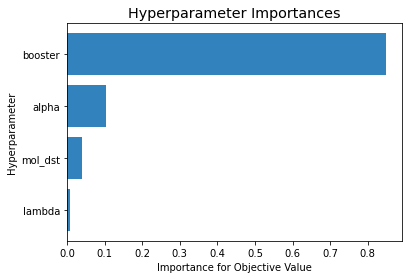

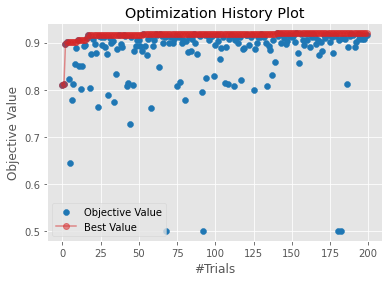

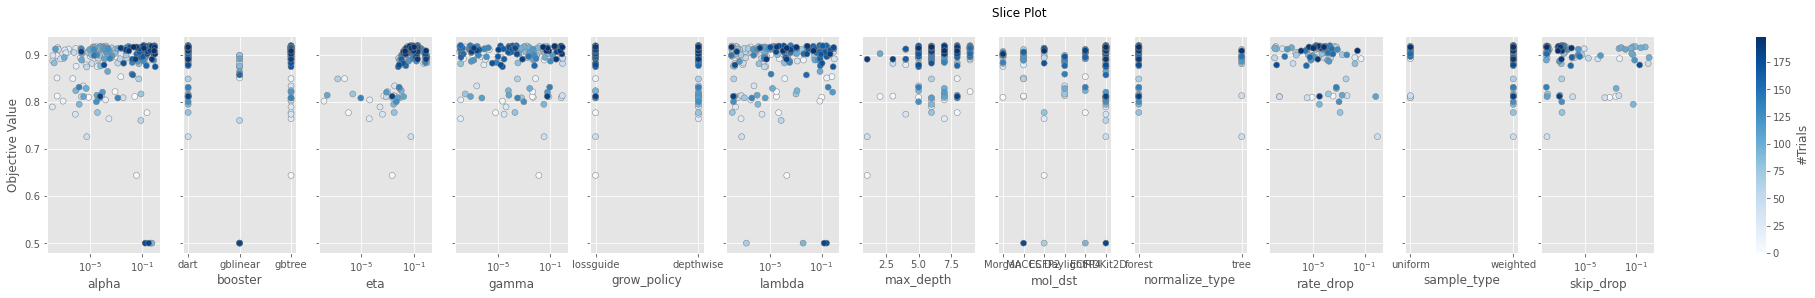

In [8]:
v1 = oviz.plot_param_importances(study)
v2 = oviz.plot_optimization_history(study)
v3 = oviz.plot_slice(study)

def fig_name(name):
    return(optuna_dir + "output/" + "{}.{}_{}.{}.{}_{}.pdf".format(my_time.hour, my_time.minute, my_time.month, my_time.day, my_time.year, name))

v1.figure.savefig(fig_name("HyperparameterImportance"))
v2.figure.savefig(fig_name("OptimizationHistory"))

Finally, I train a new model based on the best trial.

In [9]:
# train new model based on the best trial
best_xgb_model = xgb.Booster()
best_xgb_model.load_model(model_dir + "xgboost_model_{}.json".format(best_trial.number))

# save model for this loop
best_xgb_model.save_model(model_dir + "best_xgboost_model.json")

I visualize the best tree with the `matplotlib` library. This requires `pip install graphviz`, see [this tutorial](https://www.datacamp.com/community/tutorials/xgboost-in-python).

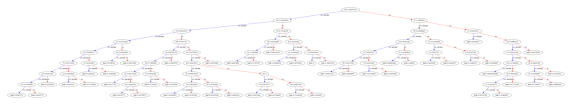

In [30]:
xgb.plot_tree(best_xgb_model, num_trees=1)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig(fig_name("BestXGBoostTree"), dpi = 900)

I also plot feature importance.

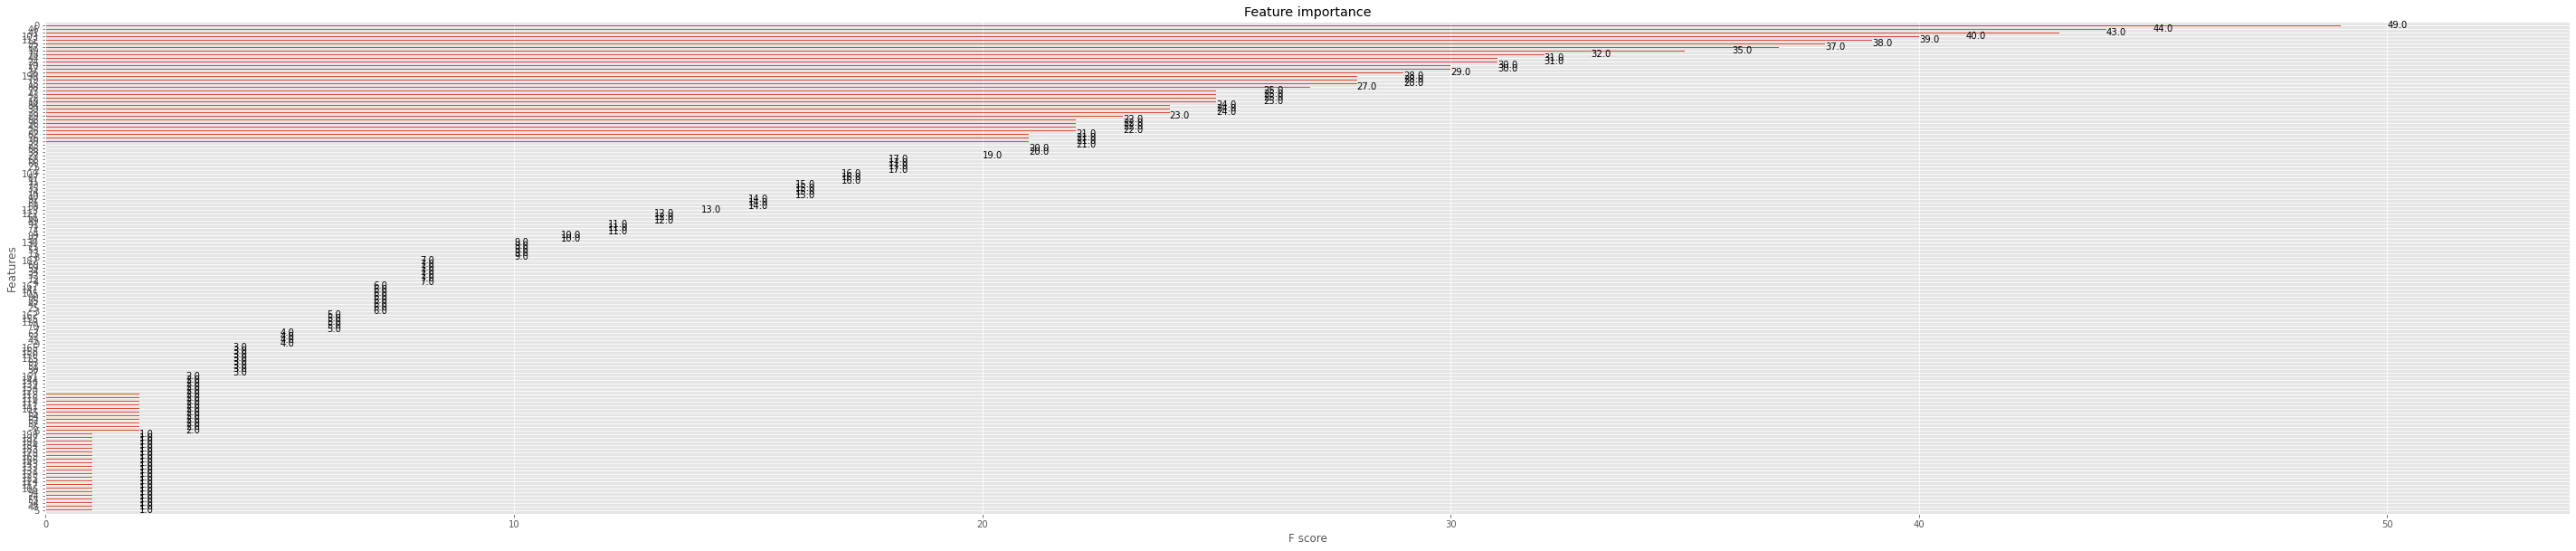

In [11]:
xgb.plot_importance(best_xgb_model)
plt.rcParams['figure.figsize'] = [10, 30]
plt.savefig(fig_name("FeatureImportance"), dpi = 900)

Now, I evaluate on the independent test set.

In [12]:
# convert fingerprint
test_converter = MolConvert(src = 'SMILES', dst = best_trial.params['mol_dst'])
test_features = pd.DataFrame([test_converter(x) for x in test['Drug']])
dtest = xgb.DMatrix(test_features, label = test['Y'])

Test set evaluation.

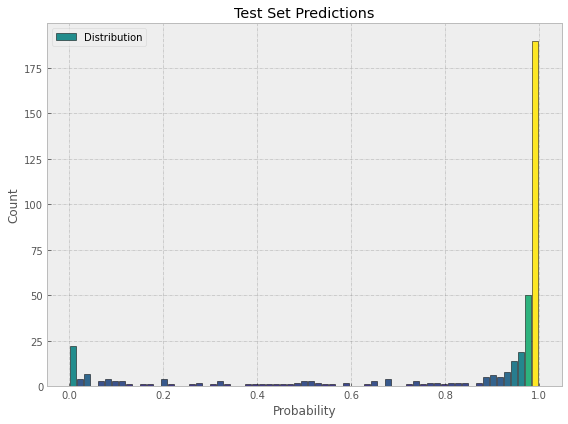

In [13]:
# evaluate on test set
y_pred_test = best_xgb_model.predict(dtest)

# set style
with plt.style.context('bmh'):

    # create figure
    fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

    # add grid lines
    axs.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.6)

    # create histogram
    max_value = np.max(y_pred_test)
    bin_width = 0.015
    nbins = np.ceil(max_value/bin_width)
    N, bins, patches = axs.hist(y_pred_test, bins = int(nbins), rwidth = 0.85, edgecolor = "black")

    # set color
    fracs = ((N**(1 / 3))/N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # add labels
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.legend(['Distribution'])
    plt.title("Test Set Predictions")

# show plot
plt.savefig(fig_name("TestSetPredictions"), dpi = 900)

Finally, evaluate the results of the predictions.

In [14]:
# append predictions to test set object
predictions[name] = y_pred_test
predictions_list.append(predictions)

# evaluate predictions on test set
# print(group.evaluate_many(predictions_list))
group.evaluate(predictions_list[0])

{'bbb_martins': {'roc-auc': 0.895}}

Next, I plot the ROC curve on the independent test set.

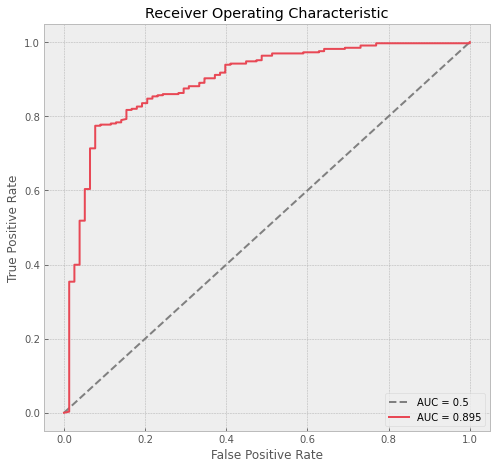

In [15]:
# get FPR and TPR
fpr, tpr, _ = metrics.roc_curve(test['Y'],  y_pred_test)
auc = metrics.roc_auc_score(test['Y'],  y_pred_test)

# create ROC curve
# see plt.style.available for available styles
with plt.style.context('bmh'):
    plt.figure(figsize = (8, 7.5))
    plt.plot([0, 1], [0, 1], label = "AUC = 0.5", color = "gray", linestyle = '--', linewidth = 2)
    plt.plot(fpr, tpr, label = "AUC = " + str(round(auc, 3)), color = "#E84855", linewidth = 2)
    plt.title("Receiver Operating Characteristic")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc = 4)

# save figure
plt.savefig(fig_name("TestSetROC"), dpi = 900)

In [16]:
print("AUC: " + str(auc))

AUC: 0.8946607254534085


In [26]:
sum(test['Y'] == 1)

328

In [27]:
len(train_val)

1624

In [29]:
import torch

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)

[]
